**Transformation lead-lag, Mars 2024**

In [3]:
#!pip install yfinance

In [1]:
import matplotlib.pyplot as plt
import torch

In [2]:
import torch
import matplotlib.pyplot as plt

# Paramètres modèle B&S
torch.manual_seed(2024)

S0 = 100  ;mu = 0.05  ;sigma = 0.2  ;T = 1.0  

#T=len(data_torch)
dt = 1/252  # jours de trading

N = int(T / dt)  
#S_t=data_torch
times = torch.linspace(0, T, N)
W_t = torch.cumsum(torch.randn(N)*torch.sqrt(torch.tensor(dt)), dim=0)  
S_t = S0 * torch.exp((mu - 0.5 * sigma ** 2) * times + sigma * W_t)


def compute_lead_lag_transform(path: torch.Tensor) -> torch.Tensor:
    
    path_LL = torch.empty((len(path)-1, 2))
    
    for i in range(len(path)-1):
        if i % 2 == 0:  # Si l'indice est pair
            path_LL[i] = torch.tensor([path[i], path[i+1]])
        else:  # Si l'indice est impair
            path_LL[i] = torch.tensor([path[i+1], path[i]])
    
    return path_LL



lead_lag_path = compute_lead_lag_transform(S_t)
times_LL = torch.linspace(0, T, lead_lag_path.shape[0])


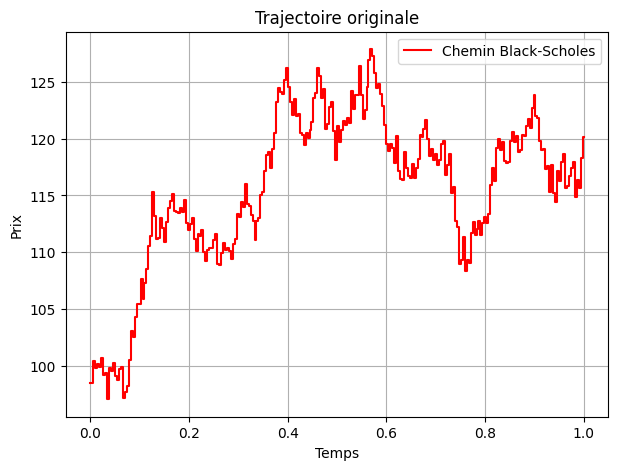

In [4]:
plt.figure(figsize=(7, 5))
plt.grid(True)
plt.step(times.numpy(), S_t.numpy(), label="Chemin Black-Scholes", color='red', where='mid')

plt.title('Trajectoire originale')
plt.legend()
plt.xlabel('Temps')
plt.ylabel('Prix')
chemin_complet = './img/illustration_lead_lag_BS.pdf'
plt.savefig(chemin_complet, format='pdf')

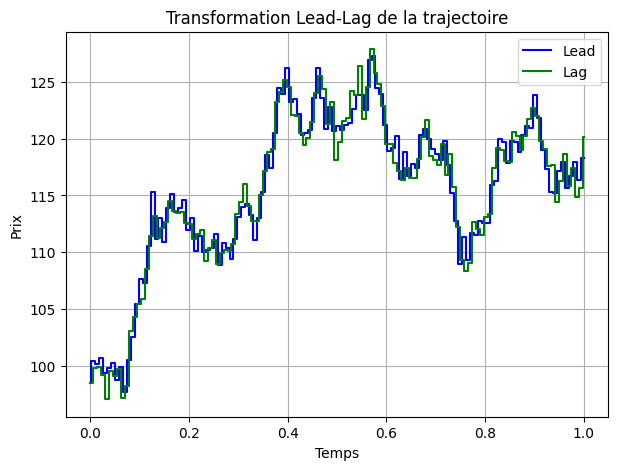

In [5]:

plt.figure(figsize=(7, 5))
plt.step(times_LL.numpy(), lead_lag_path[:, 0].numpy(), label="Lead", color='blue', where='mid')
plt.step(times_LL.numpy(), lead_lag_path[:, 1].numpy(), label="Lag", color='green', where='mid')

plt.title('Transformation Lead-Lag de la trajectoire')
plt.xlabel('Temps')
plt.ylabel('Prix')
plt.legend()
plt.grid(True)


chemin_complet = './img/illustration_lead_lag.pdf'
plt.savefig(chemin_complet, format='pdf')

plt.show()



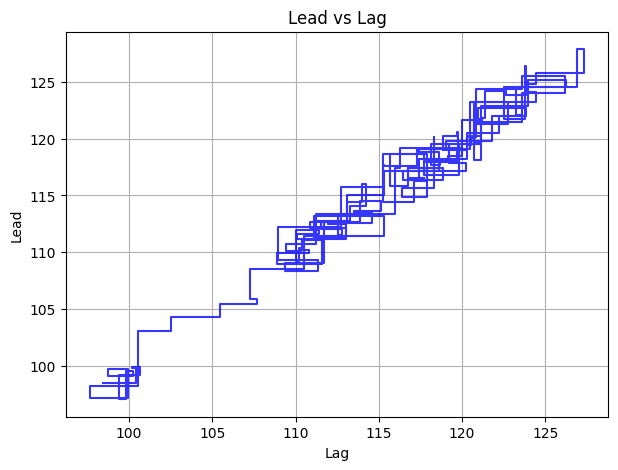

In [6]:
lead = lead_lag_path[:, 0]
lag = lead_lag_path[:, 1]

plt.figure(figsize=(7, 5))
plt.plot(lead, lag, linestyle='-', alpha=0.79,color='blue')
plt.title('Lead vs Lag')
plt.xlabel('Lag')
plt.ylabel('Lead')
plt.grid(True)
chemin_complet = './img/lead_vs_lag.pdf'
plt.savefig(chemin_complet, format='pdf')


plt.show()

**Transformation Lead-lag Hoff (comme dans le papier)**

In [7]:
import yfinance as yf
import matplotlib.pyplot as plt

symbol = '^GSPC'
data = yf.download(symbol, start='2020-03-01',end='2020-04-30')
data=data['Adj Close']
data_torch=torch.tensor(data.to_numpy())

T = (data.index[-1] - data.index[0]).days/30  # Durée en années
N = len(data)
times = torch.linspace(0, T, N)
S_t=data_torch

[*********************100%%**********************]  1 of 1 completed


In [8]:
type(data)

pandas.core.series.Series

In [54]:
def compute_lead_lag_transform_Hoff(times: torch.Tensor, S_t: torch.Tensor):
    N = len(times) // 2
    X_lead = torch.zeros_like(S_t)
    X_lag = torch.zeros_like(S_t)
       
    for t in range(2 * N):
        k = t // 2  # indice de la paire (k, k+1)

        # Calcul de X_lead
        
        if t % 2 == 0:  # t est pair, donc t ∈ [2k, 2k+1]
            
            X_lead[t] = S_t[k + 1]
        else:  # t est impair
            if t <= 2 * k + 1:
                X_lead[t] = S_t[k + 1] + 2 * (times[t] - times[2 * k + 1]) * (S_t[k + 2] - S_t[k + 1])
            else:
                X_lead[t] = S_t[k + 2]

        # Calcul de X_lag
        
        if t < 2 * k + 1.5:
            X_lag[t] = S_t[k]
        else:
            X_lag[t] = S_t[k + 1] + 2 * (times[t] - times[2 * k + 1.5]) * (S_t[k + 1] - S_t[k])

    return X_lead[:-1], X_lag[:-1]  #2N points

X_lead, X_lag = compute_lead_lag_transform_Hoff(times, S_t)

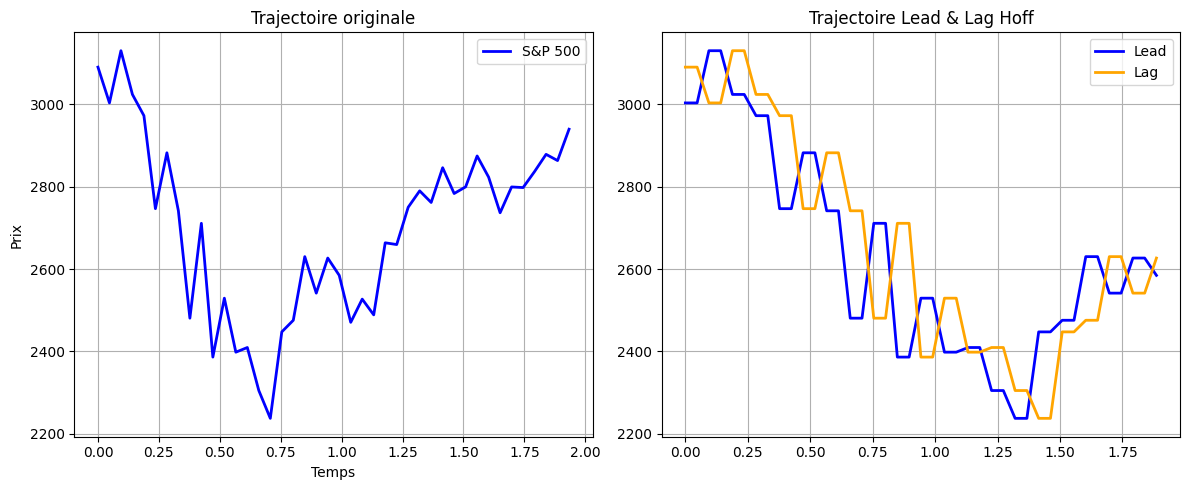

In [12]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1) 
plt.plot(times.numpy(), S_t.numpy(), label='S&P 500', color='blue', linewidth=2)
plt.title('Trajectoire originale')
plt.xlabel('Temps')
plt.ylabel('Prix')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)  
plt.plot(times.numpy()[:-1], X_lead.numpy(), label='Lead', color='blue', linewidth=2)
plt.plot(times.numpy()[:-1], X_lag.numpy(), label='Lag', color='orange', linewidth=2)
plt.title('Trajectoire Lead & Lag Hoff')
plt.legend()
plt.grid(True)

plt.savefig('./img/S&P500_lead_lag_Hoff.pdf', format='pdf')

plt.tight_layout()
plt.show()

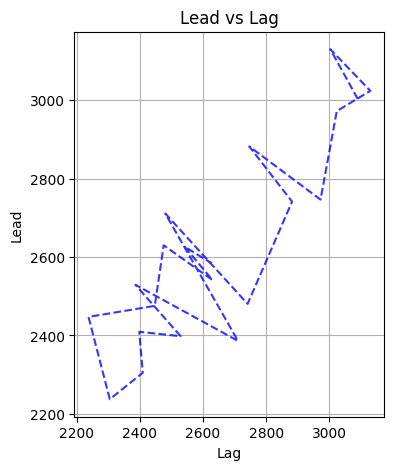

In [19]:
plt.figure(figsize=(4, 5))
plt.plot(X_lag, X_lead, linestyle='--', alpha=0.79,color='blue')
plt.title('Lead vs Lag')
plt.xlabel('Lag')
plt.ylabel('Lead')
plt.grid(True)

chemin_complet = './img/lead_vs_lag_Hoff.pdf'
plt.savefig(chemin_complet, format='pdf')

plt.show()

**version dev fonction**

In [11]:
import matplotlib.pyplot as plt
import torch

def compute_lead_lag_transform_Hoff_v2(S_t: torch.Tensor):
    T=S_t.shape[0]
    N = len(S_t)
    times = torch.linspace(0, T, N)
    N = len(times) // 2
    X_lead = torch.zeros_like(S_t)
    X_lag = torch.zeros_like(S_t)
       
    for t in range(2 * N):
        k = t // 2  # indice de la paire (k, k+1)

        # Calcul de X_lead
        
        if t % 2 == 0:  # t est pair, donc t ∈ [2k, 2k+1]
            
            X_lead[t] = S_t[k + 1]
        else:  # t est impair
            if t <= 2 * k + 1:
                X_lead[t] = S_t[k + 1] + 2 * (times[t] - times[2 * k + 1]) * (S_t[k + 2] - S_t[k + 1])
            else:
                X_lead[t] = S_t[k + 2]

        # Calcul de X_lag
        
        if t < 2 * k + 1.5:
            X_lag[t] = S_t[k]
        else:
            X_lag[t] = S_t[k + 1] + 2 * (times[t] - times[2 * k + 1.5]) * (S_t[k + 1] - S_t[k])

    return X_lead[:-1], X_lag[:-1]  #2N points


X_lead, X_lag = compute_lead_lag_transform_Hoff_v2(S_t)
